# Initialisation

In [1]:
# import initial packages, if others needed later, will be imported in later code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Load data
df = pd.read_csv("UsArrests.csv", index_col = 0)
df.head()

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


# Pre-processing

In [2]:
# Describe to look at general stats
df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


In [3]:
# Check for null data
df.isnull().sum()

Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

No missing data that needs to be replaced, so no further pre-processing required in this respect.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


Two floats (murder and rape) and two integers (assault and urbanpop), with 50 cities represented in the data.

# Visualisation

<function matplotlib.pyplot.show(close=None, block=None)>

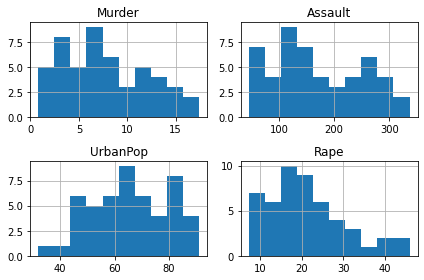

In [5]:
# Start with histograms to visualise the frequency distributions
df.hist()
plt.tight_layout()
plt.show

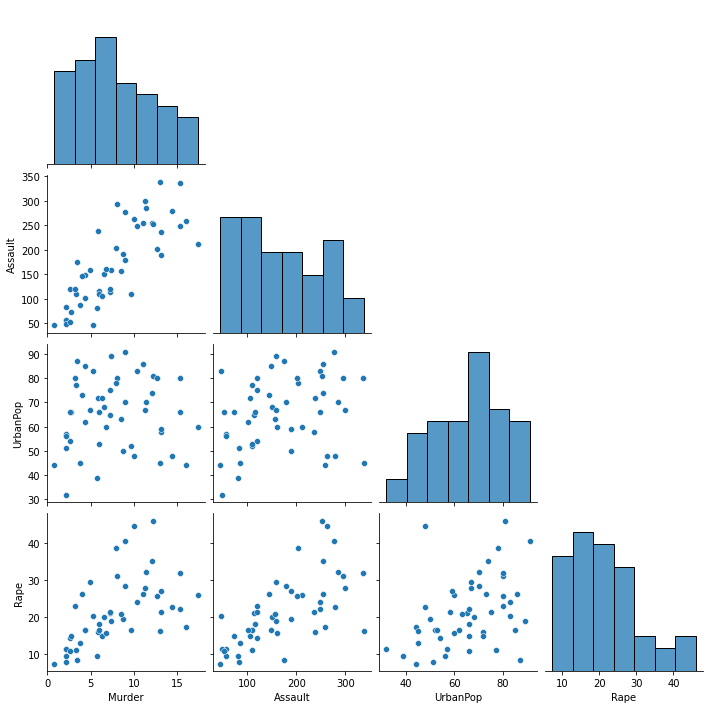

In [6]:
# Using a pairplot and heatmap to define any correlations
sns.pairplot(df, corner = True)

<AxesSubplot: >

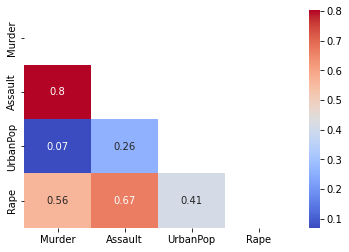

In [7]:
corr = df.corr()
matrix = np.triu(corr)
sns.heatmap(corr, cmap="coolwarm", annot = True, mask = matrix)

From both the pairplots and heatmap, it is apparent that murder and assault is strongly positively correlated, with weaked correlations between rape and assault, and rape and murder. Urban population is weakly correlated with rape and assault, but extremely weak correlation to murder.

# Clustering

In [10]:
# Starting with PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

np.set_printoptions(precision=2)

X = df.values
X_std = StandardScaler().fit_transform(X)

pca = PCA()

X_std_trans = pca.fit_transform(X_std)

df_pca = pd.DataFrame(X_std_trans)
df_pca.head()

,0,1,2,3
0,0.985566,1.133392,-0.444269,0.156267
1,1.950138,1.073213,2.040003,-0.438583
2,1.763164,-0.745957,0.054781,-0.834653
3,-0.141420,1.119797,0.114574,-0.182811
4,2.523980,-1.542934,0.598557,-0.341996


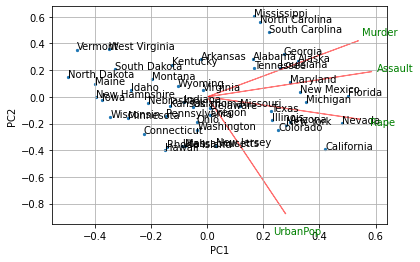

In [19]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = cities[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

    # Adapted from: https://ostwalprasad.github.io/machine-learning/PCA-using-python.html

labels =corr.columns
cities = df.index

biplot(X_std_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels))
plt.show()

In [93]:
# Feature importance

pc1 = abs(pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs(pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.535899,0.418181
1,Assault,0.583184,0.187986
2,UrbanPop,0.278191,0.872806
3,Rape,0.543432,0.167319


Text(0.5, 1.0, 'Cumulative Explained Variance')

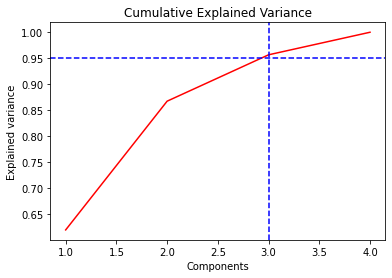

In [41]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red')
plt.axhline(y = 0.95, color = 'b', linestyle = '--')
plt.axvline(x = 3.0, color = 'b', linestyle = '--')
plt.title("Cumulative Explained Variance")

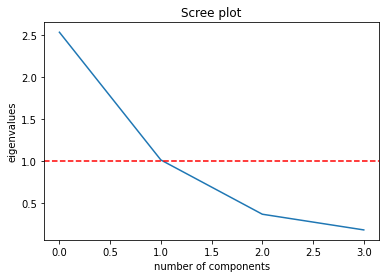

In [32]:
# Scree plot to help determine number of components to use in the analysis
plt.plot(pca.explained_variance_)
plt.xlabel('number of components')
plt.ylabel('eigenvalues')
plt.title("Scree plot")
plt.axhline(y = 1, color = 'r', linestyle = '--')
plt.show()

3 components explains over 95% of the variance in the cumulative variance plot - this will be used in the clustering dendrograms. To note, the scree plot is not very useful as there is no clear elbow and only 1 component has an eigenvalue of ≥1. 

In [20]:
pca_df = pd.DataFrame(X_std_trans[:,0:4], index = df.index)
pca_df.head()

,0,1,2,3
City,,,,
Alabama,0.985566,1.133392,-0.444269,0.156267
Alaska,1.950138,1.073213,2.040003,-0.438583
Arizona,1.763164,-0.745957,0.054781,-0.834653
Arkansas,-0.141420,1.119797,0.114574,-0.182811
California,2.523980,-1.542934,0.598557,-0.341996


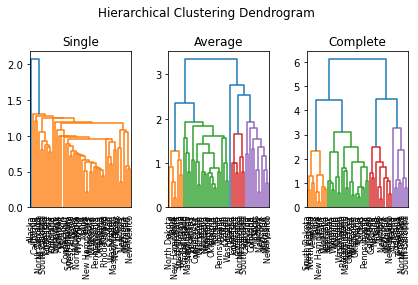

In [26]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.tight_layout()
plt.show()

The best dendrogram appears to be using the complete linkage. This will be further plotted below.

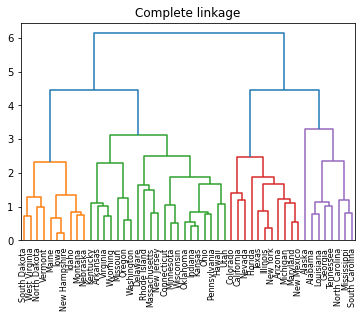

In [54]:
plt.title("Complete linkage")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)
plt.show()

In [74]:
# Clusters - translate to readable names
label = fcluster(linkage(pca_df, 'complete'), 4, criterion='maxclust')
df_clst = pd.DataFrame()
df_clst['City'] = df.index
df_clst['label'] = label

for i in range(4):
   elements = df_clst[df_clst['label']==i+1]['City'].tolist()  
   size = len(elements)
   print(f'Cluster {i+1}: {elements}\n')

Cluster 1: ['Idaho', 'Iowa', 'Maine', 'Montana', 'Nebraska', 'New Hampshire', 'North Dakota', 'South Dakota', 'Vermont', 'West Virginia']

Cluster 2: ['Arkansas', 'Connecticut', 'Delaware', 'Hawaii', 'Indiana', 'Kansas', 'Kentucky', 'Massachusetts', 'Minnesota', 'Missouri', 'New Jersey', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'Utah', 'Virginia', 'Washington', 'Wisconsin', 'Wyoming']

Cluster 3: ['Arizona', 'California', 'Colorado', 'Florida', 'Illinois', 'Maryland', 'Michigan', 'Nevada', 'New Mexico', 'New York', 'Texas']

Cluster 4: ['Alabama', 'Alaska', 'Georgia', 'Louisiana', 'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee']



K-means clustering to be performed using 4 clusters:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


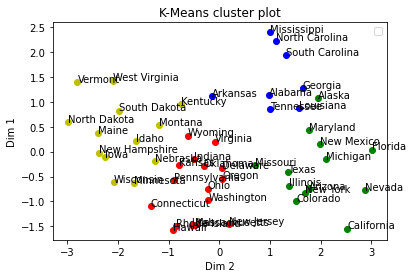

In [77]:
from sklearn.cluster import KMeans

x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=4
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
#cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = cities[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

In [78]:
# Groups - translate to readable names
group0_indices = np.argwhere(cluster_labels==0).transpose()[0]
group1_indices = np.argwhere(cluster_labels==1).transpose()[0]
group2_indices = np.argwhere(cluster_labels==2).transpose()[0]
group3_indices = np.argwhere(cluster_labels==3).transpose()[0]

group0 = np.array(cities)[group0_indices]
group1 = np.array(cities)[group1_indices]
group2 = np.array(cities)[group2_indices]
group3 = np.array(cities)[group3_indices]

print(f"Group 1: {group0}\n")
print(f"Group 2: {group1}\n")
print(f"Group 3: {group2}\n")
print(f"Group 4: {group3}\n")

Group 1: ['Connecticut' 'Delaware' 'Hawaii' 'Indiana' 'Kansas' 'Massachusetts'
 'New Jersey' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island'
 'Utah' 'Virginia' 'Washington' 'Wyoming']

Group 2: ['Alabama' 'Arkansas' 'Georgia' 'Louisiana' 'Mississippi' 'North Carolina'
 'South Carolina' 'Tennessee']

Group 3: ['Alaska' 'Arizona' 'California' 'Colorado' 'Florida' 'Illinois'
 'Maryland' 'Michigan' 'Missouri' 'Nevada' 'New Mexico' 'New York' 'Texas']

Group 4: ['Idaho' 'Iowa' 'Kentucky' 'Maine' 'Minnesota' 'Montana' 'Nebraska'
 'New Hampshire' 'North Dakota' 'South Dakota' 'Vermont' 'West Virginia'
 'Wisconsin']



# Analysis

From dendrogram clustering:
- Cluster 1: Idaho, Iowa, Maine, Montana, Nebraska, New Hampshire, North Dakota, South Dakota, Vermont, West Virginia
- Cluster 2: Arkansas, Connecticut, Delaware, Hawaii, Indiana, Kansas, Kentucky, Massachusetts, Minnesota, Missouri, New Jersey, Ohio, Oklahoma, Oregon, Pennsylvania, Rhode Island, Utah, Virginia, Washington, Wisconsin, Wyoming
- Cluster 3: Arizona, California, Colorado, Florida, Illinois, Maryland, Michigan, Nevada, New Mexico, New York, Texas
- Cluster 4: Alabama, Alaska, Georgia, Louisiana, Mississippi, North Carolina, South Carolina, Tennessee

From K-means clustering:
- Group 1: Connecticut, Delaware, Hawaii, Indiana, Kansas, Massachusetts, New, Jersey, Ohio, Oklahoma, Oregon, Pennsylvania, Rhode, Island, Utah, Virginia, Washington, Wyoming
- Group 2: Alabama, Arkansas, Georgia, Louisiana, Mississippi, North, Carolina, South, Carolina, Tennessee
- Group 3: Alaska, Arizona, California, Colorado, Florida, Illinois, Maryland, Michigan, Missouri, Nevada, New, Mexico, New, York, Texas
- Group, 4: Idaho, Iowa, Kentucky, Maine, Minnesota, Montana, Nebraska, New, Hampshire, North, Dakota, South, Dakota, Vermont, West, Virginia, Wisconsin

The two separate clustering methods results in slightly different clusters but overall, there are some similarities. Interestingly, the cities that tend to change groups are the midwest states (e.g. Idaho, Alabama, Kentucky) and Alaska.<br><br>
Looking at the largest and smallest groups from both sets:

In [90]:
# K-means largest group
df_kmeans_large = df.iloc[group0_indices]
print("Largest group:\n")
print(df_kmeans_large)
print()

# K-means smallest group
df_kmeans_small = df.iloc[group1_indices]
print("Smallest group:\n")
print(df_kmeans_small)

Largest group:

               Murder  Assault  UrbanPop  Rape
City                                          
Connecticut       3.3      110        77  11.1
Delaware          5.9      238        72  15.8
Hawaii            5.3       46        83  20.2
Indiana           7.2      113        65  21.0
Kansas            6.0      115        66  18.0
Massachusetts     4.4      149        85  16.3
New Jersey        7.4      159        89  18.8
Ohio              7.3      120        75  21.4
Oklahoma          6.6      151        68  20.0
Oregon            4.9      159        67  29.3
Pennsylvania      6.3      106        72  14.9
Rhode Island      3.4      174        87   8.3
Utah              3.2      120        80  22.9
Virginia          8.5      156        63  20.7
Washington        4.0      145        73  26.2
Wyoming           6.8      161        60  15.6

Smallest group:

                Murder  Assault  UrbanPop  Rape
City                                           
Alabama           13.2  

In [92]:
# Largest group from dendrogram
dend_array_large = np.array(['Arkansas', 'Connecticut', 'Delaware', 'Hawaii', 'Indiana', 'Kansas', 'Kentucky', 'Massachusetts', 'Minnesota', 'Missouri', 'New Jersey', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'Utah', 'Virginia', 'Washington', 'Wisconsin', 'Wyoming'])
df_dend_large = df.loc[dend_array_large]

print("Largest group:\n")
print(df_dend_large)
print()

# Smallest group from dendrogram
dend_array_small = np.array(['Alabama', 'Alaska', 'Georgia', 'Louisiana', 'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee'])
df_dend_small = df.loc[dend_array_small]
print("Smallest group:\n")
print(df_dend_small)
print()

Largest group:

               Murder  Assault  UrbanPop  Rape
City                                          
Arkansas          8.8      190        50  19.5
Connecticut       3.3      110        77  11.1
Delaware          5.9      238        72  15.8
Hawaii            5.3       46        83  20.2
Indiana           7.2      113        65  21.0
Kansas            6.0      115        66  18.0
Kentucky          9.7      109        52  16.3
Massachusetts     4.4      149        85  16.3
Minnesota         2.7       72        66  14.9
Missouri          9.0      178        70  28.2
New Jersey        7.4      159        89  18.8
Ohio              7.3      120        75  21.4
Oklahoma          6.6      151        68  20.0
Oregon            4.9      159        67  29.3
Pennsylvania      6.3      106        72  14.9
Rhode Island      3.4      174        87   8.3
Utah              3.2      120        80  22.9
Virginia          8.5      156        63  20.7
Washington        4.0      145        73  26

In general, these clusters tend to show similar levels of murder, assault, and rape. Additionally, while some a slightly differently classified, these cities tend to have similar levels of proportion of populations that live in an urban environment. Lower levels of these crimes are seen with higher urban population levels.